<a href="https://colab.research.google.com/github/kimtoto23/Network_Simulation_CMCP/blob/main/NetworkSimulation_CMCP_GeneticAlgorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connected Maximum Coverage Problem using GA Algorithm

##### google drive mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##### package import

In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
from IPython.core.display import Image
from networkx.drawing.nx_pydot import to_pydot
import random
import matplotlib.pyplot as plt
import math
import sys
import heapq
from itertools import chain
from collections import defaultdict
import time
import itertools
from PIL import Image
import copy
import random
import pickle

#### Dataset: Node & Edge weight

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/UAM_입지선정/유전알고리즘/edge.csv', index_col= 0)
df

,0,1,2,3,4,5,6,7,8,9,10,11
0,0,15,0,0,24,0,18,0,0,0,0,0
1,15,0,22,0,0,0,0,0,0,0,0,0
2,0,22,0,18,16,0,0,0,20,0,0,0
3,0,0,18,0,0,12,0,0,0,0,0,0
4,24,0,16,0,0,0,25,12,24,0,0,0
5,0,0,0,12,0,0,0,0,12,0,0,22
6,18,0,0,0,25,0,0,15,0,22,0,0
7,0,0,0,0,12,0,15,0,30,0,25,0
8,0,0,20,0,24,12,0,30,0,0,19,19
9,0,0,0,0,0,0,22,0,0,0,19,0


In [ ]:
node_edge = pd.DataFrame({"node": [0,1,2,3,4,5,6,7,8,9,10,11], "demand":[15,10,12,18,5,24,11,16,13,22,19,20]})
node_edge

,node,demand
0,0,15
1,1,10
2,2,12
3,3,18
4,4,5
5,5,24
6,6,11
7,7,16
8,8,13
9,9,22


# Reconstruction  of Graph using Dijkstra
---

In [ ]:
def dijkstra_map(df):
  df.columns= df.columns.astype('str')
  df = df.T
  df.columns= df.columns.astype('str')
  df = df.T
  inf = sys.maxsize
  df = df.replace(0,inf)
  df_dict = df.to_dict()

  re_df = pd.DataFrame()
  for start in df.columns:
    distances = {node: float('inf') for node in df_dict}  # start로 부터의 거리 값을 저장하기 위함
    distances[start] = 0  # 시작 값은 0이어야 함
    queue = []
    heapq.heappush(queue, [distances[start], start])  # 시작 노드부터 탐색 시작 하기 위함.

    while queue:  # queue에 남아 있는 노드가 없으면 끝
      current_distance, current_destination = heapq.heappop(queue)  # 탐색 할 노드, 거리를 가져옴.

      if distances[current_destination] < current_distance:  # 기존에 있는 거리보다 길다면, 볼 필요도 없음
        continue

      for new_destination, new_distance in df_dict[current_destination].items():
        distance = current_distance + new_distance  # 해당 노드를 거쳐 갈 때 거리
        if distance < distances[new_destination]:  # 알고 있는 거리 보다 작으면 갱신
          distances[new_destination] = distance
          heapq.heappush(queue, [distance, new_destination])  # 다음 인접 거리를 계산 하기 위해 큐에 삽입

    re_df = pd.concat([re_df, pd.DataFrame.from_dict(distances, orient = 'index')], axis = 1)

  re_df.columns = df.columns.astype('int')
  re_df = re_df.T

  return re_df

# Using Prim Algorithm to find Connected Node(Minimum Spanning Tree)
---

## Prim

In [ ]:
inf = sys.maxsize

## 그림 그리기 위한 보조함수 엣지랑 노드 받기(엣지와 노드)
def get_edges_and_nodes (G):
  inf = sys.maxsize
  edges = [(i, j) for i in range(len(G)) for j in range(len(G))
                if i != j and G[i][j] != inf]
  edges += [(j, i) for i in range(len(G)) for j in range(len(G))
            if i != j and G[i][j] != inf]
  nodes = [*range(0, len(G), 1)]
  return edges, nodes

## 그림 그리는 함수(MST_PRIM에서 받은 return)
def draw_graph(MST):
  inf = sys.maxsize
  graphEdges, nodes = get_edges_and_nodes(MST[0])
  G=nx.Graph()

  for node in nodes:
      G.add_node(node)

  edge_list = []
  for edge in graphEdges:
      if edge in MST[1]:
          l, r = edge[0], edge[1]
          if l > r:
              l, r = r, l
          G.add_edge(l, r, color="red", weight=3)
      else:
          edge_p = edge[1], edge[0]
          if edge_p not in MST[1] and edge_p not in edge_list:
              G.add_edge(edge[0], edge[1], color="black", weight=1)

  colors = nx.get_edge_attributes(G, 'color').values()
  weights = nx.get_edge_attributes(G, 'weight').values()

  pos = nx.shell_layout(G)
  nx.draw(G, pos, edge_color=colors, width=list(weights), with_labels=True)

  edge_labels = G.edges
  formatted_edge_labels = {(elem[0], elem[1]): MST[0][elem[0]][elem[1]] for elem in edge_labels}
  nx.draw_networkx_edge_labels(G, pos, edge_labels=formatted_edge_labels, font_color='red')
  plt.show()

## PRIM 알고리즘을 위한 보조함수
def find_minimum (G, U, V):
  inf = sys.maxsize
  difference = [item for item in V if item not in U]
  min, u, v, exists = inf, 0, 0, False

  for c_u in U:
      for c_v in V:
          if G[c_u][c_v] != sys.maxsize and c_v in difference:
                  weight = G[c_u][c_v]
                  if weight < min:
                      min, u, v = weight, c_u, c_v
  if min != inf:
      exists = True

  return v, (u, v), min, exists

## PRIM 알고리즘으로 구하는 MST(입력값: pick_fisrt_node에서 만든 리스트 안에 있는 데이터프레임을 list로 입력, 시작 노드, 연결성을 고려한 길이)
def MST_PRIM (G, s, connect):
  inf = sys.maxsize
  V = {*range(0, len(G), 1)}
  U = {s}
  E_prim = set()
  total_weight = 0
  while U != V:
      gr_node, min_branch, weight, exists = find_minimum(G, U, V)
      if not exists:
          raise Exception("Node was not found!")
      U.add(gr_node)
      E_prim.add(min_branch)
      if weight > connect:
        raise Exception("Connection is too long!")
      draw_graph([G, E_prim, 0])                       ## 그림 안 보고 싶으면 이거 지우기
      total_weight += weight
  return [G, E_prim, total_weight]

def print_result (MST):
    print("Minimum spanning tree has been found!")
    print("Edges of MST: " + str(MST[1]))
    print("Weight: " + str(MST[2]))

In [ ]:
##NEW
## 연결성을 고려한 초기해 계산: 임의의 random 노드 비복원 추출함수_리스트안에 데이터프레임 저장 (입력값: n x n dataframe, 추출개수, 랜덤횟수)
def find_fisrt_gen(df, count, initial_num, connect):
  df.columns , df.index = pd.to_numeric(df.columns) , pd.to_numeric(df.index)
  inf = sys.maxsize
  df = df.replace(0,inf)
  available_node = []
  chromosome = []
  while len(chromosome) != initial_num:
    ls = []
    ex = []
    v = int(10e6*random.random())
    ls = df.loc[df.sample(n=count, random_state= v).index, df.sample(n=count, random_state= v).index]
    ex = ls.values.tolist()
    i=0
    for i in range(count):
      try:
        MST = MST_PRIM(ex,i,connect)
        add =[]
        add = ls.columns.tolist()
        add.sort()
        available_node.append(add)
      except:
        continue

    chromosome = [sorted(list(items)) for items in list(set(map(tuple,available_node)))]
    # chromosome = [sorted(list(items)) for items in list(set(map(tuple,chromosome)))]

  return chromosome

## Crossover Chromosome
---

In [ ]:
def crossover(chromosome, total_demand, connect):
  # df.columns , df.index = pd.to_numeric(df.columns) , pd.to_numeric(df.index)
  # inf = sys.maxsize
  # df = df.replace(0,inf)

  offspring = 0
  available_node = []
  chormosome_length = 0
  while chormosome_length < int(len(chromosome)):
    pick = random.choices(chromosome, k = 2, weights = total_demand)
    dad = 0
    dad = pick[0]
    mom = 0
    mom = pick[1]
    if dad == mom:
      available_node.append(dad)
    else:
      dad_gene = random.sample(dad, k = int(len(chromosome[0])-1))
      mom_gene = random.sample(list(set(mom).difference(set(dad))), k = 1)
      offspring = 0
      offspring = copy.deepcopy(dad_gene)
      offspring.extend(mom_gene)

      df.columns = df.columns.astype('int')
      ef =df.loc[offspring,offspring].values.tolist()
      i = 0
      for i in range(int(len(chromosome[0]))):
        try:
          MST = MST_PRIM(ef,i,connect)
          offspring.sort()
          available_node.append(offspring)
        except:
          continue

    next_sample = [list(item) for item in list(set(map(tuple,[sorted(list(items)) for items in list(set(map(tuple,available_node)))]))) ]
    # next_sample = [list(item) for item in list(set(map(tuple,[sorted(list(items)) for items in list(set(map(tuple,next_sample)))]))) ]

    if len(next_sample) > len(chromosome):
      next_sample = random.sample(next_sample,len(chromosome))

    chormosome_length = 0
    chormosome_length = int(len(next_sample))
  return next_sample

## Chromosome Mutation
---

In [ ]:
def mutation(next_sample, connect):
  # df.columns , df.index = pd.to_numeric(df.columns) , pd.to_numeric(df.index)
  # inf = sys.maxsize
  # df = df.replace(0,inf)

  next_gen = copy.deepcopy(next_sample)
  n = int(len(next_sample))
  i =0

  if int(n/10) == 1:
    deduct = np.array(random.sample(next_sample, int(len(next_sample)/10))).flatten().tolist()
    const = []
    while (const == []):
      const = random.sample(deduct,int(len(next_sample[0])-1))
      mut = random.sample(np.delete(np.array(df.index),deduct).tolist(), 1)
      const.extend(mut)
      const.sort()
      if (const in next_sample) == False:
        df.columns = df.columns.astype('int')
        ef =df.loc[const,const].values.tolist()
        for j in range(int(len(next_sample[0]))):
          try:
            MST = MST_PRIM(ef,j,connect)

            next_gen.remove(deduct)
            next_gen.append(const)

          except:
            continue
      else:
        const = []
      if ((deduct[i] in next_gen)&(const != deduct)) == False:
        break
      const = []

##########################################################################################
  elif int(n/10) > 1:
    deduct = np.array(random.sample(next_sample, int(n/10))).tolist()

    i = 0
    for i in range(int(n/10)):
      const = []
      while (const == []):
        const = random.sample(deduct[i], int(len(next_sample[0])-1))
        mut = random.sample(np.delete(np.array(df.index),deduct[i]).tolist(), 1)
        const.extend(mut)
        const.sort()
        if (const in next_sample) == False:
          df.columns = df.columns.astype('int')
          ef =df.loc[const,const].values.tolist()
          for j in range(int(len(next_sample[0]))):
            try:
              MST = MST_PRIM(ef,j,connect)
              next_gen.remove(deduct[i])
              next_gen.append(const)
            except:
              continue
        else:
          const = []
        if ((deduct[i] in next_gen)&(const != deduct[i])) == False:
          break
        const = []
##########################################################################################
  else:
    next_gen = copy.deepcopy(next_sample)
  return next_gen

## Objective Functinon(Maximum Coeverage)
---

In [ ]:
def find_coverage_node(graph, length, node):   ### graph: 데이터프레임, length: coverage length, node: chromosome node  eg)  [[2, 6, 7], [7, 9, 10], [2, 3, 4], [2, 7, 10], [2, 5, 7]]     => return chromosome

  inf = sys.maxsize

  graph = graph.replace(0,inf)
  re = []
  coverage = copy.deepcopy(node)
  i = 0
  for i in range(len(coverage)):
    cov_node = []
    for j in coverage[i]:
      cov_node.append(graph[j].loc[graph[j] <= length ].index.tolist())

    coverage[i].extend(sum(cov_node,[]))
    coverage[i] = list(set(coverage[i]))

  return coverage

In [ ]:
def objective_function(graph_weight, node):
  total_demand = []
  i = 0
  for i in range(len(node)):
    total_demand.append(int(sum((node_edge.loc[node_edge.node.isin(node[i]), ['demand']]).values)))

  return total_demand

In [ ]:
def CMCP_with_GA(data, count, initial_num, connect, length, node_edge, gen_num):

  gen_time_stamp = []                  #######################
  start_time = time.process_time() #######################

  procedure_GA = []
  global df
  df = dijkstra_map(data)
  chromosome = find_fisrt_gen(df,count, initial_num, connect)
  coverage = find_coverage_node(df, length, chromosome)
  total_demand = objective_function(node_edge, coverage)

  i = 0
  chro_demand = [ [chromosome[i], total_demand[i] ] for i in range(len(chromosome)) ]
  chro_demand.sort(reverse=True, key= lambda x:x[1])

  procedure_GA.append(chro_demand)

#######################################################################################################
  mid_s_time = time.process_time() #######################

  next_sample = crossover(chromosome, total_demand, connect)
  next_gen = mutation(next_sample, connect)
  next_coverage = find_coverage_node(df, length, next_gen)
  next_total_demand = objective_function(node_edge, next_coverage)
  i = 0
  next_demand = [ [next_gen[i], next_total_demand[i] ] for i in range(len(next_gen)) ]
  next_demand.sort(reverse=True, key= lambda x:x[1])

  procedure_GA.append(next_demand)

  mid_e_time = time.process_time() #######################

  mid_time = mid_e_time - mid_s_time #######################
  gen_time_stamp.append(mid_time) #######################

#######################################################################################################

  for _ in range(int(gen_num-1)):

    mid_s_time = 0 #######################
    mid_s_time = time.process_time() #######################

    next_sample = []
    next_sample = crossover(next_gen, next_total_demand, connect)
    next_gen = mutation(next_sample, connect)
    next_coverage = find_coverage_node(df, length, next_gen)
    next_total_demand = objective_function(node_edge, next_coverage)
    i = 0
    next_demand = [ [next_gen[i], next_total_demand[i] ] for i in range(len(next_gen)) ]
    next_demand.sort(reverse=True, key= lambda x:x[1])

    procedure_GA.append(next_demand)

    mid_e_time = 0 #######################
    mid_e_time = time.process_time() #######################

    mid_time = 0 #######################
    mid_time = mid_e_time - mid_s_time #######################
    gen_time_stamp.append(mid_time) #######################


  end_time = time.process_time() #######################
  procedure_time = end_time - start_time #######################

  return procedure_GA, procedure_time, gen_time_stamp


# Next

## Example test

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/UAM_입지선정/유전알고리즘/edge.csv', index_col= 0)

In [ ]:
# procedure_GA, procedure_time, gen_time_stamp = CMCP_with_GA(df, 3, 20, 30, 20, node_edge, 4)

In [ ]:
# procedure_GA

In [ ]:
# procedure_time

317.523196654

In [ ]:
# gen_time_stamp

[61.139453180000146, 68.34112054499997, 60.596051664000015, 48.06872309100004]

In [ ]:
# procedure_GA[0][0]

[[0, 4, 8], 145]

In [ ]:
# best_score = [ procedure_GA[i][0] for i in range(len(procedure_GA)) ]

In [ ]:
best_score

[[[0, 4, 8], 145],
 [[1, 2, 8], 136],
 [[0, 4, 8], 145],
 [[5, 7, 8], 138],
 [[3, 7, 8], 138]]

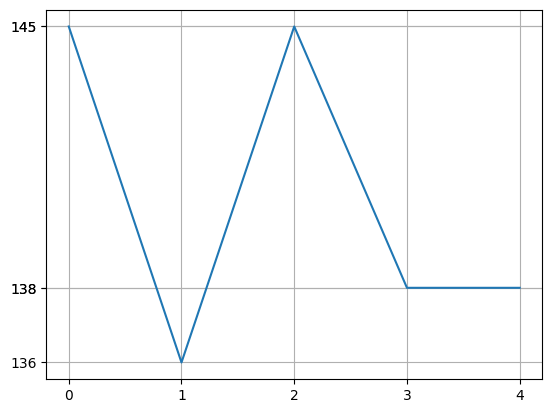

In [ ]:
x = [i for i in range(int(len(best_score)))]
y = [best_score[i][1] for i in range(int(len(best_score)))]


plt.plot(x,y)
plt.grid(True)
plt.xticks(x)
plt.yticks(y)
plt.show()

In [ ]:
result = []
for _ in range(5):
  best_score = []
  df = pd.read_csv('/content/drive/MyDrive/UAM_입지선정/유전알고리즘/edge.csv', index_col= 0)
  procedure_GA, procedure_time, gen_time_stamp = CMCP_with_GA(df, 3, 20, 30, 20, node_edge, 4)
  best_score = [ procedure_GA[i][0] for i in range(len(procedure_GA)) ]
  result.append(best_score)


In [ ]:
result

[[[[0, 4, 8], 145],
  [[0, 4, 8], 145],
  [[7, 8, 10], 142],
  [[7, 8, 10], 142],
  [[3, 7, 8], 138]],
 [[[7, 8, 10], 142],
  [[7, 8, 10], 142],
  [[7, 8, 10], 142],
  [[0, 4, 8], 145],
  [[0, 4, 8], 145]],
 [[[2, 7, 8], 138],
  [[7, 8, 10], 142],
  [[7, 8, 10], 142],
  [[7, 8, 10], 142],
  [[7, 8, 10], 142]],
 [[[3, 7, 8], 138],
  [[3, 7, 8], 138],
  [[0, 4, 8], 145],
  [[0, 4, 8], 145],
  [[0, 4, 8], 145]],
 [[[7, 8, 10], 142],
  [[7, 8, 10], 142],
  [[7, 8, 10], 142],
  [[7, 8, 10], 142],
  [[7, 8, 10], 142]]]

## show result

In [ ]:
test_sample = []
total_test_hour = 0
######################
file_name_1 = '/content/drive/MyDrive/UAM_입지선정/data/10_15_100/0/procedure_GA_1.pkl'
with open(file_name_1, 'rb') as f:
    load_a = pickle.load(f)
test_sample.extend(load_a)

file_name_1 = '/content/drive/MyDrive/UAM_입지선정/data/10_15_100/0/procedure_time_1.pkl'
with open(file_name_1, 'rb') as f:
    time = pickle.load(f)
total_test_hour += time
######################
for i in range(1,10):
    file_name_1 = '/content/drive/MyDrive/UAM_입지선정/data/10_15_100/{}/procedure_GA_1.pkl'.format(i)
    with open(file_name_1, 'rb') as f:
        load_a = pickle.load(f)
    test_sample.extend(load_a)

    file_name_1 = '/content/drive/MyDrive/UAM_입지선정/data/10_15_100/{}/procedure_time_1.pkl'.format(i)
    with open(file_name_1, 'rb') as f:
        time = pickle.load(f)
    total_test_hour += time

In [ ]:
file_name_1 = '/content/drive/MyDrive/UAM_입지선정/data/10_15_100/91/procedure_GA_1.pkl'
with open(file_name_1, 'rb') as f:
    load_a = pickle.load(f)
test_sample.extend(load_a)

In [ ]:
print((total_test_hour/60)//60, 'hr')

11.0 hr


In [ ]:
best_score = [ test_sample[i][0] for i in range(len(test_sample)) ]

In [ ]:
best_score

[[[35, 134, 232, 241, 265, 277, 284, 339, 341, 377], 151],
 [[28, 74, 98, 139, 163, 245, 296, 340, 343, 356], 161],
 [[198, 232, 241, 245, 265, 277, 284, 312, 341, 377], 173],
 [[73, 198, 232, 241, 265, 277, 284, 312, 339, 377], 166],
 [[32, 50, 114, 232, 245, 264, 310, 349, 388, 403], 165],
 [[32, 50, 114, 198, 232, 245, 310, 349, 388, 395], 154],
 [[35, 232, 241, 264, 277, 284, 312, 341, 377, 406], 152],
 [[32, 232, 241, 264, 277, 284, 312, 341, 377, 406], 176],
 [[32, 232, 241, 264, 277, 284, 312, 341, 403, 406], 159],
 [[32, 35, 38, 144, 198, 232, 241, 284, 339, 349], 161],
 [[114, 198, 277, 296, 310, 339, 349, 377, 388, 403], 186],
 [[114, 198, 277, 310, 312, 339, 349, 377, 388, 403], 173],
 [[35, 114, 198, 277, 310, 312, 349, 377, 388, 403], 168],
 [[35, 114, 198, 277, 310, 312, 339, 349, 388, 403], 168],
 [[35, 114, 198, 277, 310, 312, 339, 349, 388, 403], 168],
 [[35, 46, 198, 284, 339, 344, 349, 377, 388, 403], 161],
 [[35, 198, 284, 339, 341, 344, 349, 377, 388, 403], 168],
 

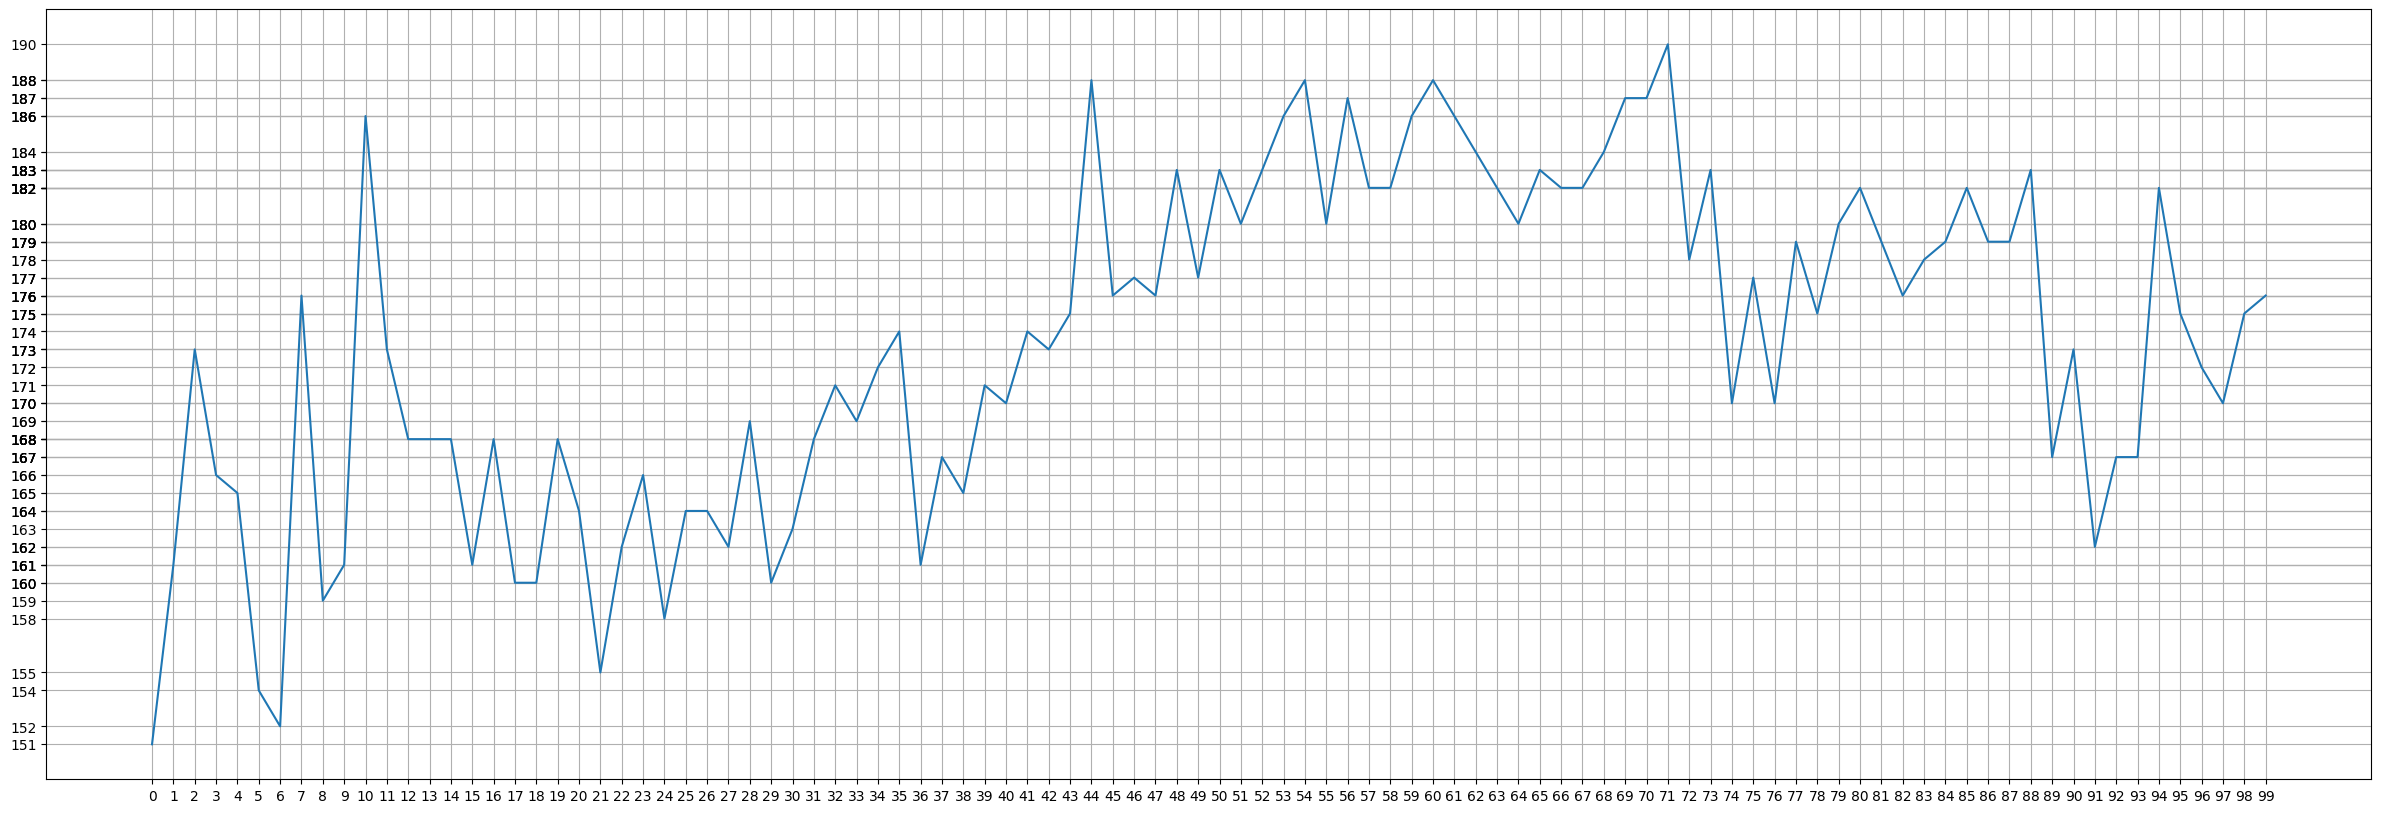

In [ ]:
x = [i for i in range(int(len(best_score)))]
y = [best_score[i][1] for i in range(int(len(best_score)))]

plt.figure(figsize=(30, 10))
plt.plot(x,y)
plt.grid(True)
plt.xticks(x)
plt.yticks(y)
plt.show()

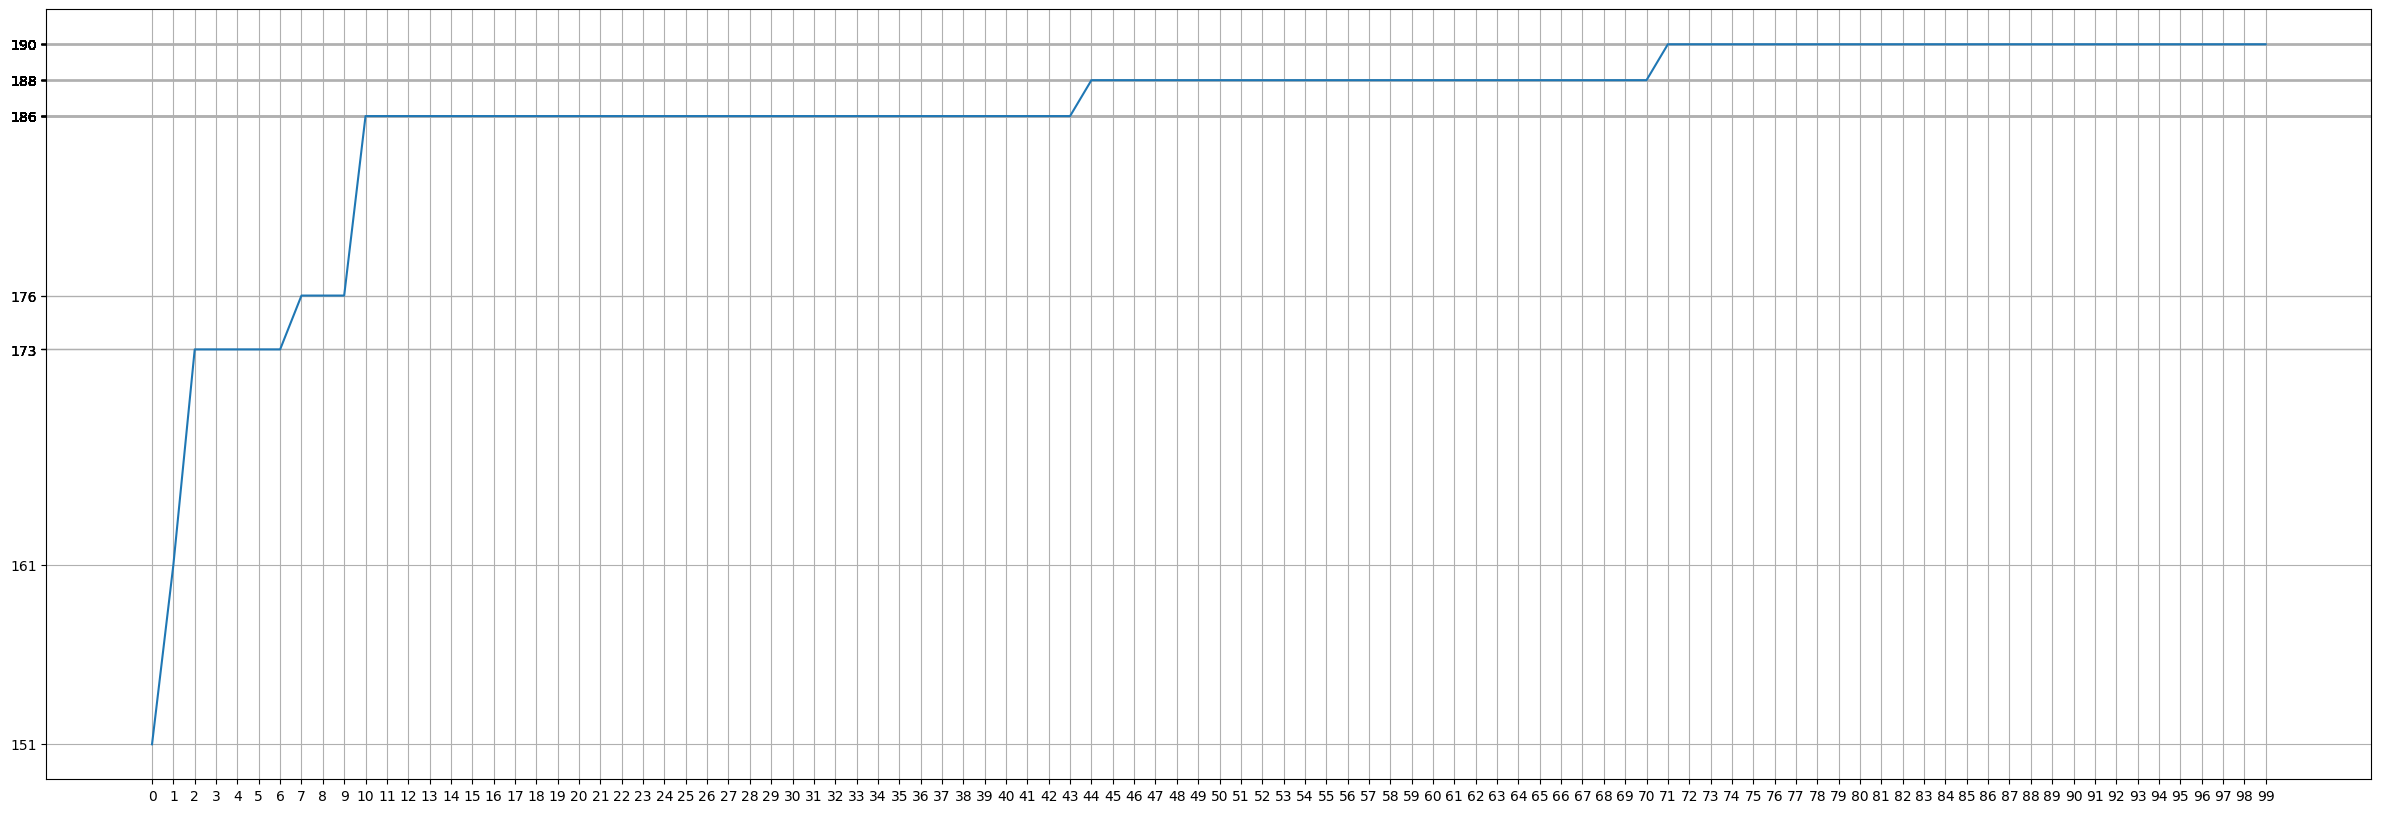

In [ ]:
x = [i for i in range(int(len(best_score)))]
y = []
y_0 = best_score[0][1]
# x.append(x_0)

for i in range(int(len(best_score))):
    if best_score[i][1] > y_0:
        y.append(best_score[i][1])
        y_0 = best_score[i][1]
    else:
        y.append(y_0)

plt.figure(figsize=(30, 10))
plt.plot(x,y)
plt.grid(True)
plt.xticks(x)
plt.yticks(y)
plt.show()

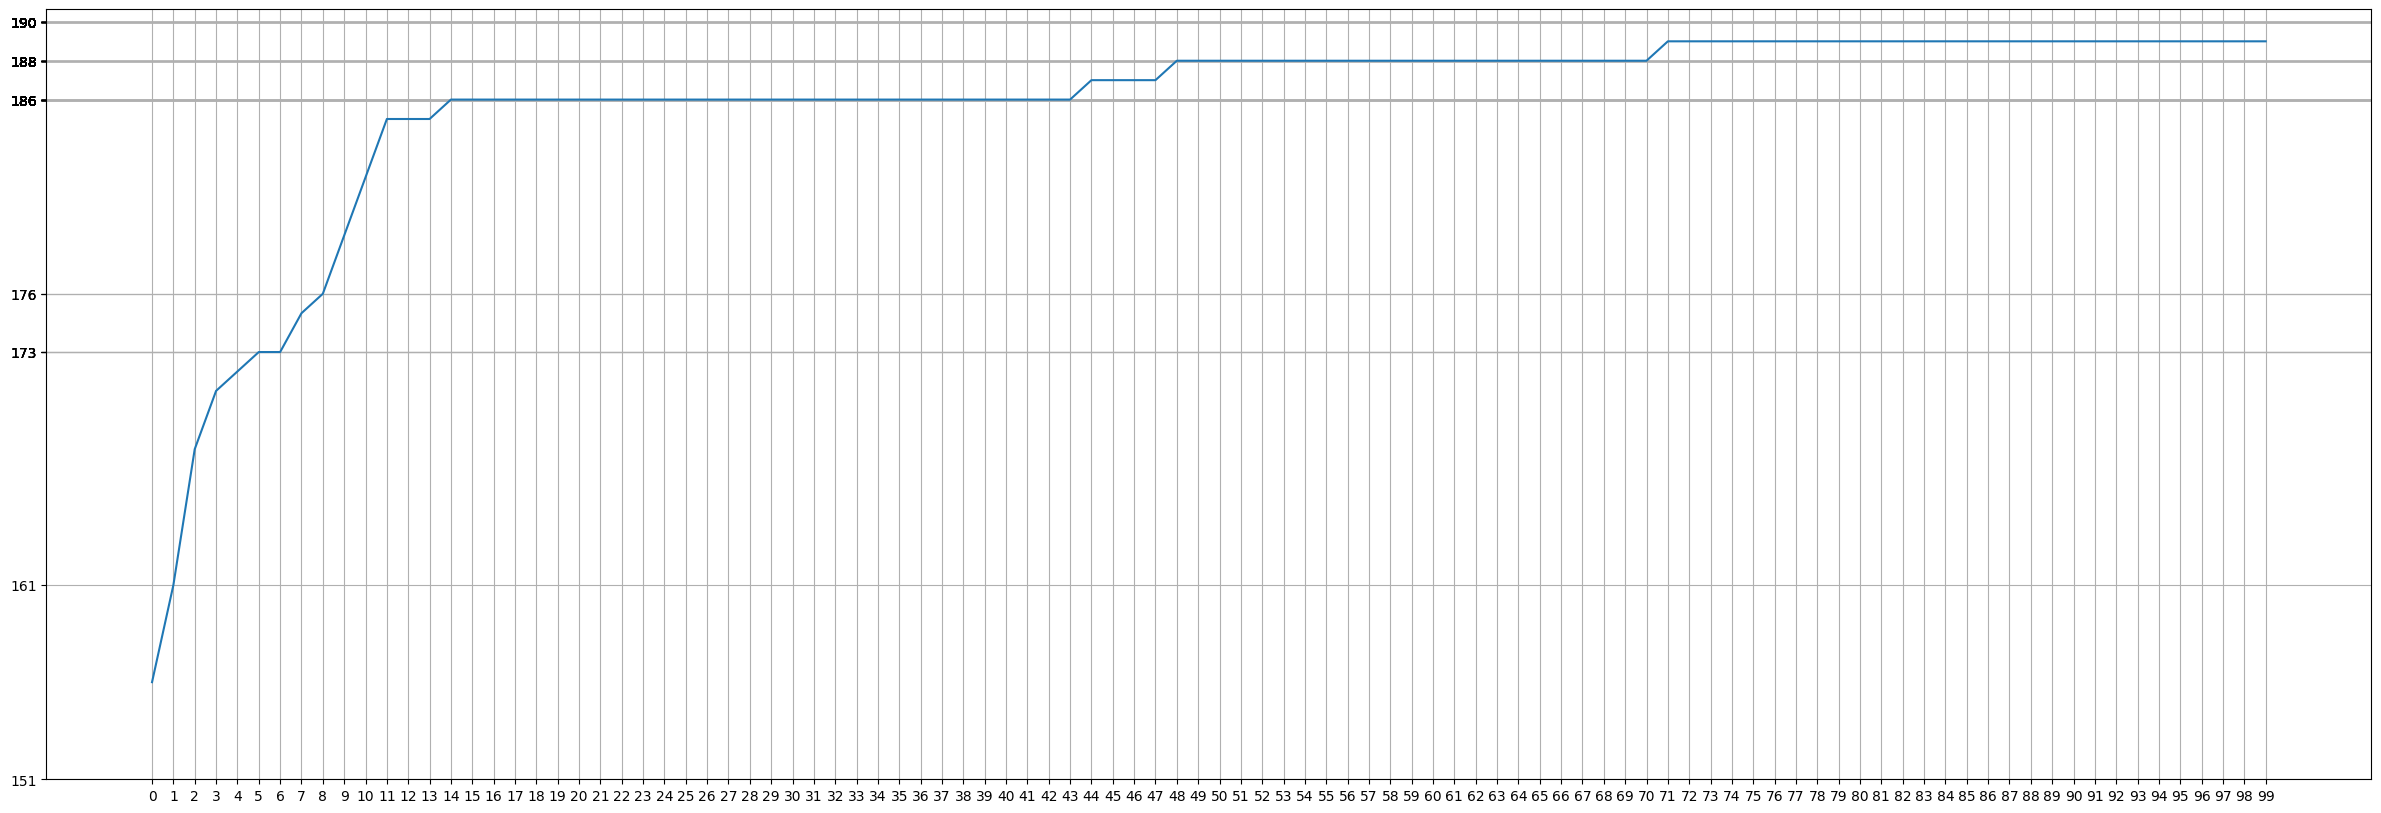

In [ ]:
from scipy.ndimage import gaussian_filter1d

x = [i for i in range(int(len(best_score)))]
y = []
y_0 = best_score[0][1]
# x.append(x_0)

for i in range(int(len(best_score))):
    if best_score[i][1] > y_0:
        y.append(best_score[i][1])
        y_0 = best_score[i][1]
    else:
        y.append(y_0)
ysmoothed = gaussian_filter1d(y, sigma=1.1)


plt.figure(figsize=(30, 10))
plt.plot(x, ysmoothed)
plt.grid(True)
plt.xticks(x)
plt.yticks(y)
plt.show()